# Problem 1

As discussed in class neutral pions decay into pairs of photons and have an invariant mass of 0.135 GeV ([more information](https://en.wikipedia.org/wiki/Pion), also note that the *charged* pion weights slightly more and does not decay into two photons).  Neutral pions are typically measured by combining pairs of photons detected in a single event.  There is not tag saying that two particular photons came from a particular pion so all pairs are made and the [invariant mass](https://en.wikipedia.org/wiki/Invariant_mass) of each pair is histogramed.  If the average number of pions in a particular event is $N$, then the average number of *pairs* in an event goes like $N^2$; so as $N$ increases the signal (number of photon pairs from a real pion) decreases relative to the background (photon pairs where each photon is from a different pion).  The signal pairs have an invariant mass that is peaked and can be described by a peak centered on 0.135 GeV and an area of $N\times S$, where S is the total number of events. The background pairs have a broad distribution in invariant mass distribution without a peak.  The total distribution can  be described as the sum of these two distributions.

the kinematics of photons from pion decay are available here:
- pi0s_1.txt
- pi0s_5.txt
- pi0s_25.txt

where the in the name "pi0s_N.txt" $N$ is the number of pions per event (so each event contains 2N photons).  The columns are labeled as event number, the x, y, z components of the momentum and the energy (both the momentum and energy are in units of GeV). 

*Useful Tip*:

For each pair of photons, calculate their total four-momentum as
$ P = p_1 + p_2 = \Big(E_1 + E_2,\; p_{x1} + p_{x2},\; p_{y1} + p_{y2},\; p_{z1} + p_{z2}\Big) $
Then, the invariant mass is computed using the formula
$ m = \sqrt{(E_1 + E_2)^2 - \Big[(p_{x1} + p_{x2})^2 + (p_{y1} + p_{y2})^2 + (p_{z1} + p_{z2})^2\Big]} $

## Part 1

Using the avialable files here, create *all* pairs of photons with the same event number.  This means that you create all possible pairs of photons within the same event and you do this for each event.  If the event contains 4 photons there are six photon pairs: AB, AC, AD, BC, BD, BC (the order doesn't matter).  Two of these pairs are from real pions and 4 are combinatoric.  If you have 1000 events with 4 photons each, you have 2000 real photons and 4000 combinatoric pairs.  Some of those combinatoric pairs will have a mass near the pion mass and some will be far away.

You will notice that the files contain different numbers of photons per event and this will change the ratio of pions to background pairs.  Histogram the mass distribution with an appropriate binning.  Make a plot of the mass distribution for each data set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit

In [2]:
# Read data, here we use pandas and read the files as dataframes for latter operations
data_1 = pd.read_csv('/home/users/russelld/DSC291/data/HW3/pi0s_1.txt', sep='\s+', header=0, names=['event_number', "px", "py", "pz", "E"])
data_5 = pd.read_csv('/home/users/russelld/DSC291/data/HW3/pi0s_5.txt', sep='\s+', header=0, names=['event_number', "px", "py", "pz", "E"])
data_25 = pd.read_csv('/home/users/russelld/DSC291/data/HW3/pi0s_25.txt', sep='\s+', header=0, names=['event_number', "px", "py", "pz", "E"])

Define a function to calculate the invairant masses of possible photon pairs.
Hint: Use "groupby" to group the data by *event_number*, and for entries with the same *event_number*, use "np.triu_indices" to avoid slow for loop and get possible combinators

In [3]:
import math

In [4]:
import matplotlib.pyplot as plt

In [5]:
#pip install numba

Below, I did it my own way using `numba` to improve the waiting time...

In [6]:
@njit
def invar_mass(array, N_pions):

    mass_list = []

    rows, cols = np.triu_indices(2*N_pions, 1)

    for event_num in range(1,int(len(array)/(2*N_pions)), 1):
        event_truth = array[0:,0] == event_num
        tmp_arr = array[event_truth] #temporary array with specific event entries

        for i,j in zip(rows, cols):
            px_sum = tmp_arr[i, 1] + tmp_arr[j, 1]
            py_sum = tmp_arr[i, 2] + tmp_arr[j, 2]
            pz_sum = tmp_arr[i, 3] + tmp_arr[j, 3]
            E_sum = tmp_arr[i, 4] + tmp_arr[j, 4]

            m2 = E_sum**2 - (px_sum**2 + py_sum**2 + pz_sum**2)

            if m2 > 0:
                inv_mass = math.sqrt(m2)
                mass_list.append(inv_mass)

            #if event_num == 2: break


    return mass_list

In [7]:
mass1 = invar_mass(data_1.values, 1)
mass5 = invar_mass(data_5.values, 5)
mass25 = invar_mass(data_25.values, 25)

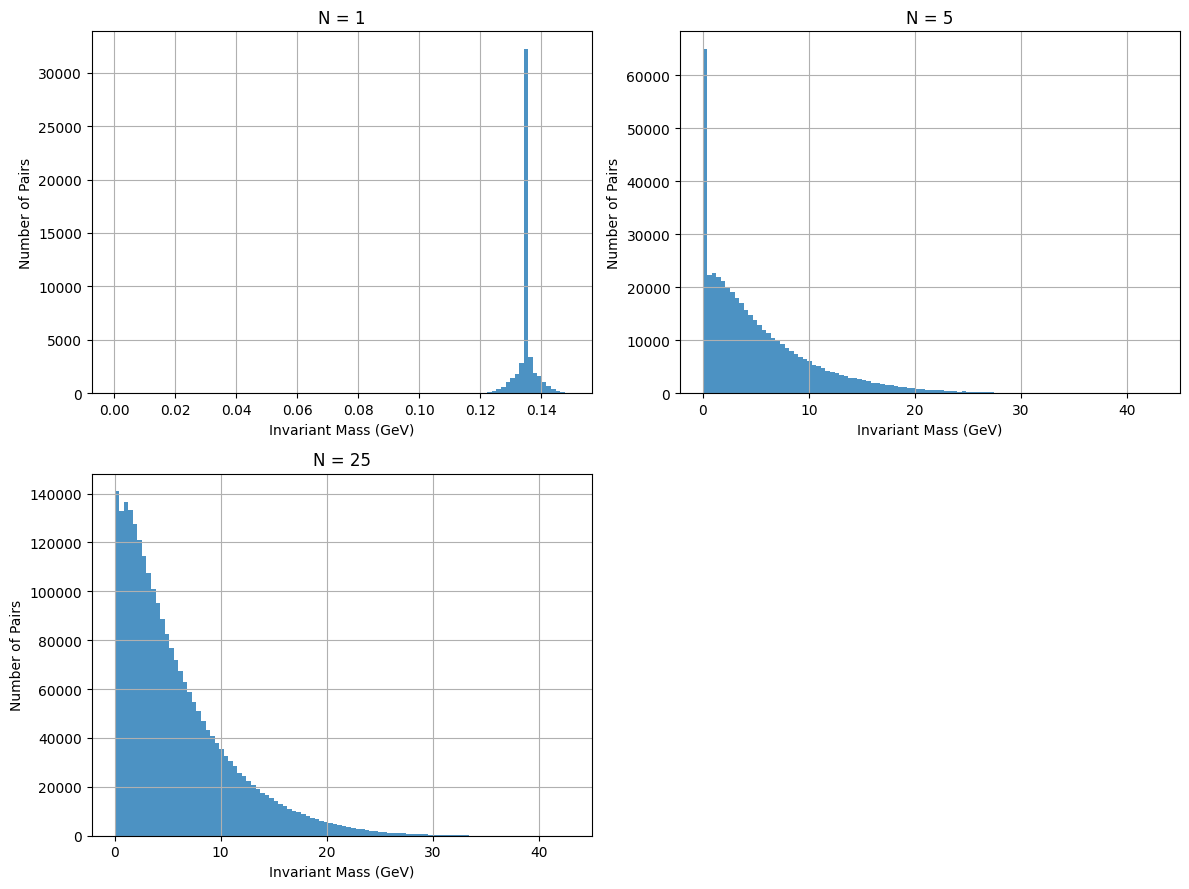

In [8]:
# Plot the invariant mass histogram
plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
plt.hist(mass1, bins=100, alpha=0.8)
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Pairs')
plt.title('N = 1')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(mass5, bins=100, alpha=0.8)
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Pairs')
plt.title('N = 5')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.hist(mass25, bins=100, alpha=0.8)
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Pairs')
plt.title('N = 25')
plt.grid(True)

plt.tight_layout()
plt.show()

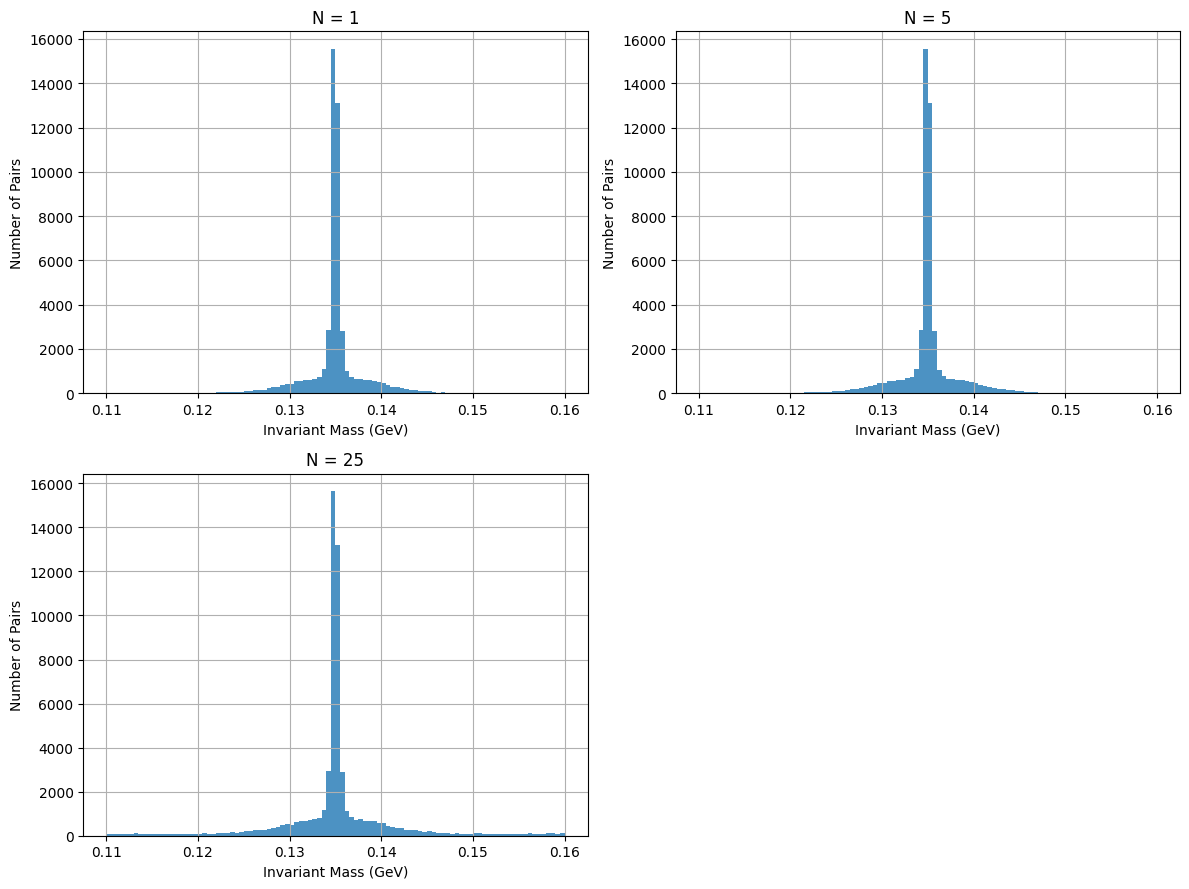

In [9]:
# Plot the invariant mass histogram
plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
cs1, bins1, _ = plt.hist(mass1, bins=100, range=(0.11, 0.16),  alpha=0.8)
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Pairs')
#plt.xlim(0, 0.15)
plt.title('N = 1')
plt.grid(True)

plt.subplot(2, 2, 2)
cs2, bins2, _  = plt.hist(mass5, bins=100, range=(0.11, 0.16),  alpha=0.8)
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Pairs')
plt.title('N = 5')
#plt.xlim(0, 10)
plt.grid(True)

plt.subplot(2, 2, 3)
cs3, bins3, _ = plt.hist(mass25, bins=100, range=(0.11, 0.16),  alpha=0.8)
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Pairs')
plt.title('N = 25')
#plt.xlim(0, 10)
plt.grid(True)

plt.tight_layout()
plt.show()

## Part 2

Look at the histograms.  If the mass of a photon pair is far from the pion mass, it probably didn't come from a pion.  However, if the mass is near the pion mass, either it came from a pion or it is a combinatoric pair.  

Find a function to fit the invariant mass distribution. What is the signal to background in the region of the pion mass (answering this question requires defining a region around the pion mass to calculate your signal; make sure you provide some justification for your definition).

Requirement: state your signal and background model, plot the invariant mass distribution and fit result, clarify your region definition, and give signal to background ratio in that region.

Hint: 
1. If gaussian cannot describe the peak well, try Breit-Wigner:
$
pdf(m) = A \frac{\Gamma^2}{(m - m_0)^2 + \Gamma^2/4}
$

2. For background a linear model should be sufficient.

3. Frist, define a fit_function first, which is pdf(signal)+pdf(backgrond)

4. Then define a $\chi^2$ function you learned from lecture

5. Use [iminuit](https://scikit-hep.org/iminuit/notebooks/basic.html) and fit the data with the fit_function, minimizing the $\chi^2$

6. With the fitted parameters, calculate the number of backgrounds within the region you defined, and subtract it from actual counts to get the number of signals, then signal to background ratio is easy

In [108]:
from iminuit import Minuit
from scipy.special import erf

def fit_signal_background(mass_list, mass_min, mass_max, n_bins , label):
    """
    Fit the invariant mass histogram using a Breit-Wigner signal plus linear background,
    and return the estimated signal and background counts in the signal region.
    """

    # Implement your code below
    # Create the histogram from mass_list
    counts, bin_edges = np.histogram(mass_list, bins=n_bins, range=(mass_min, mass_max))
    bin_width = (bin_edges[-1] - bin_edges[0]) / n_bins
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    norm_counts = counts / np.sum(counts)

    invmass = bin_centers

    
    # Define the fit function
    def fit_function(x, m, b, amp, mass, width ):
        signal = (amp * width**2)/ ((x - mass)**2 + (width/2)**2) #Breit-Wigner
        background = m*x + b # linear
        return signal + background



    # Define the chi-square function to minimize.
    def chi2(m, b, amp, mass, width ):
        y = counts
        y_mod = fit_function(invmass, m, b, amp, mass, width)
        unc = np.sqrt(counts)
        result = np.sum ( ((y - (y_mod))/unc )**2  )

        return result
    
    # Implement the Minuit fitting below
    M = Minuit(chi2, m=1, b = 1, amp=1, mass=0.135, width=1e-8 )
    M.limits = [(-10, 10), (-10,10), (0,10000), (-10,10), (-10, 10)]  # Limits for parameters
    M.migrad()  # Perform minimization

    best_m , best_b, best_amp, best_mass, best_width = M.values 
    

    total_fit = fit_function(invmass, *M.values)
    bkg_fit = fit_function(invmass, best_m, best_b,  0, best_mass, best_width)
    

    plt.figure()
    plt.bar(invmass, counts , width=bin_width, label="Histogram")
    plt.plot(invmass, fit_function(invmass, *M.values), c="red", lw=2, label="Full Fit")
    plt.plot(invmass, bkg_fit,  lw=3, label="Background",  c="black" )
    plt.xlabel("Invariant Mass")
    plt.ylabel("Counts")
    plt.title(f'{label} Pions ')
    plt.legend()

    
    S = np.sum(counts)  - np.sum(bkg_fit)
    B = np.sum( bkg_fit)


    return S, B

N=1, S=39821.50, B=567.50, S/B=70.17, uncertainty=0.5047%
N=5, S=39990.50, B=567.50, S/B=70.47, uncertainty=0.5036%
N=25, S=40912.50, B=567.50, S/B=72.09, uncertainty=0.4978%


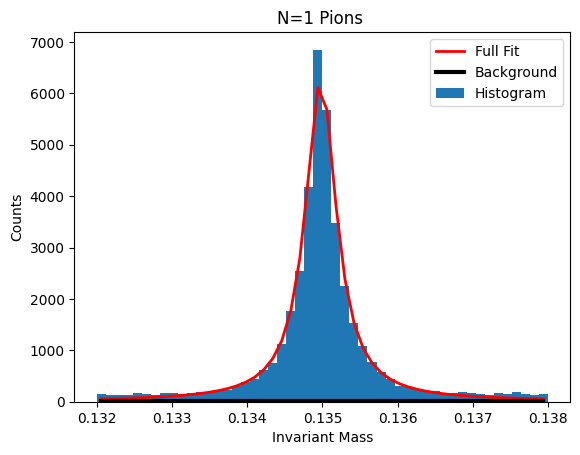

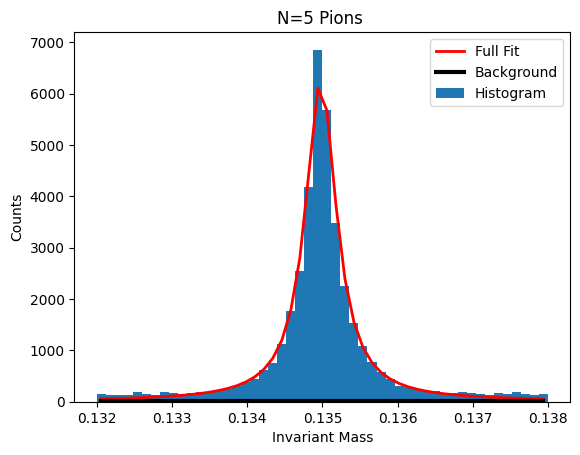

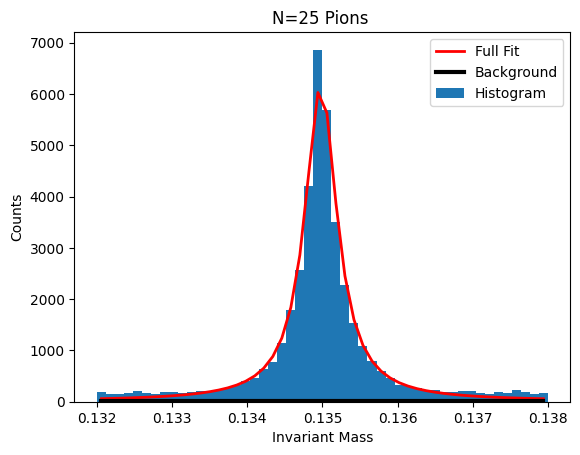

In [109]:
mass_dict = {'N=1': mass1,
             'N=5': mass5,
             'N=25': mass25
            }
for key in mass_dict.keys():
    S, B = fit_signal_background(mass_dict[key], 0.132, 0.138, 50, key)
    print (f'{key}, S=%.2f, B=%.2f, S/B=%.2f, uncertainty=%.4f%%'%(S, B, S/B, 100*np.sqrt(S+B)/S))

## Part 3

Find the number of pions in each of the histograms (making sure to remove the background).  How does the precision of the number of pions vary with the signal to background?  Explain what you find.

Answer:// Based on the numbers we found before, we observed that with a higher signal to background ratio, meaning more signal than background, the uncertainty decreases.